## Global Stats

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load CSVs
paper_clpa = pd.read_csv("paper_CLPA.csv")
paper_clpa_parallel = pd.read_csv("paper_CLPA_parallel.csv")
my_lpa = pd.read_csv("my_LPA.csv")

In [3]:
# Function to compute average minimum fitness per epoch
def average_min_fitness_per_epoch(df):
    return df.groupby(["test", "run", "epoch"])["fitness"].min().mean()

# Compute average fitness
avg_fitness_paper = paper_clpa["fitness"].mean()
avg_fitness_parallel = average_min_fitness_per_epoch(paper_clpa_parallel)
avg_fitness_my_lpa = average_min_fitness_per_epoch(my_lpa)

# Display results
print(f"Average fitness (Paper CLPA): {avg_fitness_paper:.2f}")
print(f"Average fitness (Parallel CLPA): {avg_fitness_parallel:.2f}")
print(f"Average fitness (My LPA): {avg_fitness_my_lpa:.2f}")


Average fitness (Paper CLPA): 43379.88
Average fitness (Parallel CLPA): 40041.65
Average fitness (My LPA): 34203.52


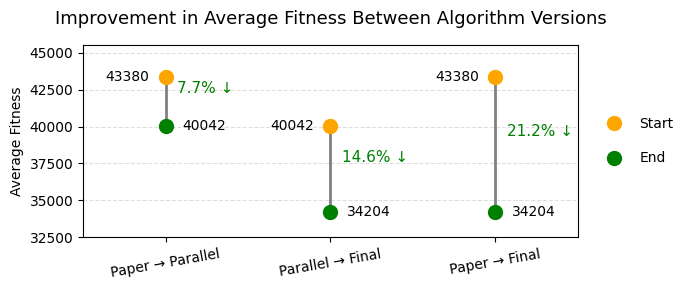

In [4]:

# Fitness values
paper = float(avg_fitness_paper)
parallel = float(avg_fitness_parallel)
final = float(avg_fitness_my_lpa)

# Comparisons
comparisons = ["Paper → Parallel", "Parallel → Final", "Paper → Final"]
start = [paper, parallel, paper]
end = [parallel, final, final]
improvements = [(s - e) / s * 100 for s, e in zip(start, end)]

# Plot setup
fig, ax = plt.subplots(figsize=(7, 3))

# Plot dumbbells
for i in range(len(comparisons)):
    ax.plot([i, i], [start[i], end[i]], color="gray", linewidth=2)
    ax.plot(i, start[i], 'o', color="orange", markersize=10, label="Start" if i == 0 else "")
    ax.plot(i, end[i], 'o', color="green", markersize=10, label="End" if i == 0 else "")

    # Add percentage improvement
    y_offset = 0.02 * start[i]  # offset based on value scale
    ax.text(i + 0.07, (start[i] + end[i]) / 2 + y_offset, f"{improvements[i]:.1f}% ↓",
            va='center', ha='left', fontsize=11, color="green")

    # Label exact values
    ax.text(i - 0.1, start[i], f"{start[i]:.0f}", va='center', ha='right', fontsize=10)
    ax.text(i + 0.1, end[i], f"{end[i]:.0f}", va='center', ha='left', fontsize=10)

# Formatting
ax.set_xticks(range(len(comparisons)))
ax.set_xticklabels(comparisons, rotation=10)
ax.set_ylabel("Average Fitness")
ax.set_title("Improvement in Average Fitness Between Algorithm Versions", fontsize=13, pad=15)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_ylim(min(end + start) * 0.95, max(end + start) * 1.05)

# Legend on the right
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, labelspacing=1.5)


# Add padding to sides and space for legend
ax.set_xlim(-0.5, len(comparisons) - 0.5)
plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()

### The average running time

In [5]:

# Load the CSV file
df = pd.read_csv("test_times.csv")

# Filter for test values from 1 to 30 (inclusive)
df_filtered = df[df['test'].between(1, 30)]

# Compute mean of each time column over the filtered rows
average_times = df_filtered[['timeBaseline', 'timeNew1', 'timeNew2']].mean()

# Rename the index for better labels
average_times.index = ['Paper CLPA', 'Parallel CLPA', 'Final LPA']

# Print the results
print("Average times for tests 1 to 30:")
print(average_times)


Average times for tests 1 to 30:
Paper CLPA       7.158931
Parallel CLPA    9.249349
Final LPA        6.409550
dtype: float64


## Batches by Tests Config

In [6]:
# Group tests into blocks of 5
def get_test_group(test_number):
    return ((test_number - 1) // 5) + 1  # test 1–5 → group 1, etc.

paper_clpa["group"] = paper_clpa["test"].apply(get_test_group)
paper_clpa_parallel["group"] = paper_clpa_parallel["test"].apply(get_test_group)
my_lpa["group"] = my_lpa["test"].apply(get_test_group)

# Function to compute average minimum fitness per epoch per group
def group_avg_min_fitness(df, label):
    min_per_epoch = df.groupby(["test", "run", "epoch"])["fitness"].min().reset_index()
    min_per_epoch["group"] = min_per_epoch["test"].apply(get_test_group)
    return min_per_epoch.groupby("group")["fitness"].mean().reset_index(name=f"avg_fitness_{label}")

# Compute average fitness for each algorithm
avg_fitness_paper = paper_clpa.groupby("group")["fitness"].mean().reset_index(name="avg_fitness_paper")
avg_fitness_parallel = group_avg_min_fitness(paper_clpa_parallel, "parallel")
avg_fitness_my_lpa = group_avg_min_fitness(my_lpa, "my_lpa")

# Merge results into one DataFrame
merged = avg_fitness_paper.merge(avg_fitness_parallel, on="group")
merged = merged.merge(avg_fitness_my_lpa, on="group")

# Display final comparison
print(merged)


   group  avg_fitness_paper  avg_fitness_parallel  avg_fitness_my_lpa
0      1       21380.146658          19529.920413        20905.490803
1      2       51513.214392          48664.749512        52372.290245
2      3       31696.056189          28672.481731        24775.108417
3      4       85198.072918          76830.484062        62195.305214
4      5       34950.818173          32969.360315        25925.744775
5      6       98709.941503          92012.719791        65553.463700


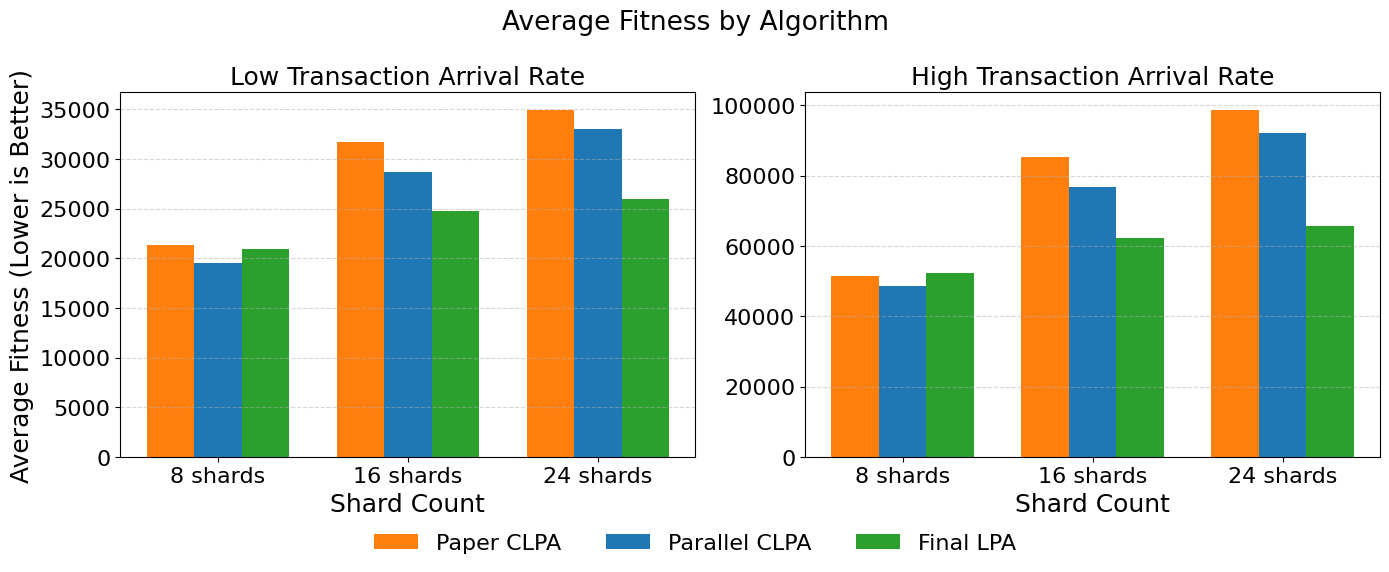

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Split into low and high tx groups
low_tx = merged[merged["group"].isin([1, 3, 5])].reset_index(drop=True)
high_tx = merged[merged["group"].isin([2, 4, 6])].reset_index(drop=True)

# Labels
labels = ["8 shards", "16 shards", "24 shards"]
x = np.arange(len(labels))
width = 0.25

# Create subplots without shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define color mapping
paper_color = '#ff7f0e'     # Orange
parallel_color = '#1f77b4'  # Blue
final_color = '#2ca02c'     # Green

# LOW TX subplot
ax1.bar(x - width, low_tx["avg_fitness_paper"], width, label='Paper CLPA', color=paper_color)
ax1.bar(x, low_tx["avg_fitness_parallel"], width, label='Parallel CLPA', color=parallel_color)
ax1.bar(x + width, low_tx["avg_fitness_my_lpa"], width, label='Final LPA', color=final_color)
ax1.set_title('Low Transaction Arrival Rate', fontsize=18)
ax1.set_xlabel('Shard Count', fontsize=18)
ax1.set_ylabel('Average Fitness (Lower is Better)', fontsize=18)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
ax1.tick_params(axis='both', labelsize=16)


# HIGH TX subplot
ax2.bar(x - width, high_tx["avg_fitness_paper"], width, label='Paper CLPA', color=paper_color)
ax2.bar(x, high_tx["avg_fitness_parallel"], width, label='Parallel CLPA', color=parallel_color)
ax2.bar(x + width, high_tx["avg_fitness_my_lpa"], width, label='Final LPA', color=final_color)
ax2.set_title('High Transaction Arrival Rate', fontsize=18)
ax2.set_xlabel('Shard Count', fontsize=18)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.grid(True, axis='y', linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)

# Shared legend
fig.legend(['Paper CLPA', 'Parallel CLPA', 'Final LPA'], loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02), fontsize=16)

# Title and layout
fig.suptitle('Average Fitness by Algorithm', fontsize=19, y=0.92)
plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.show()


## Parallel Results

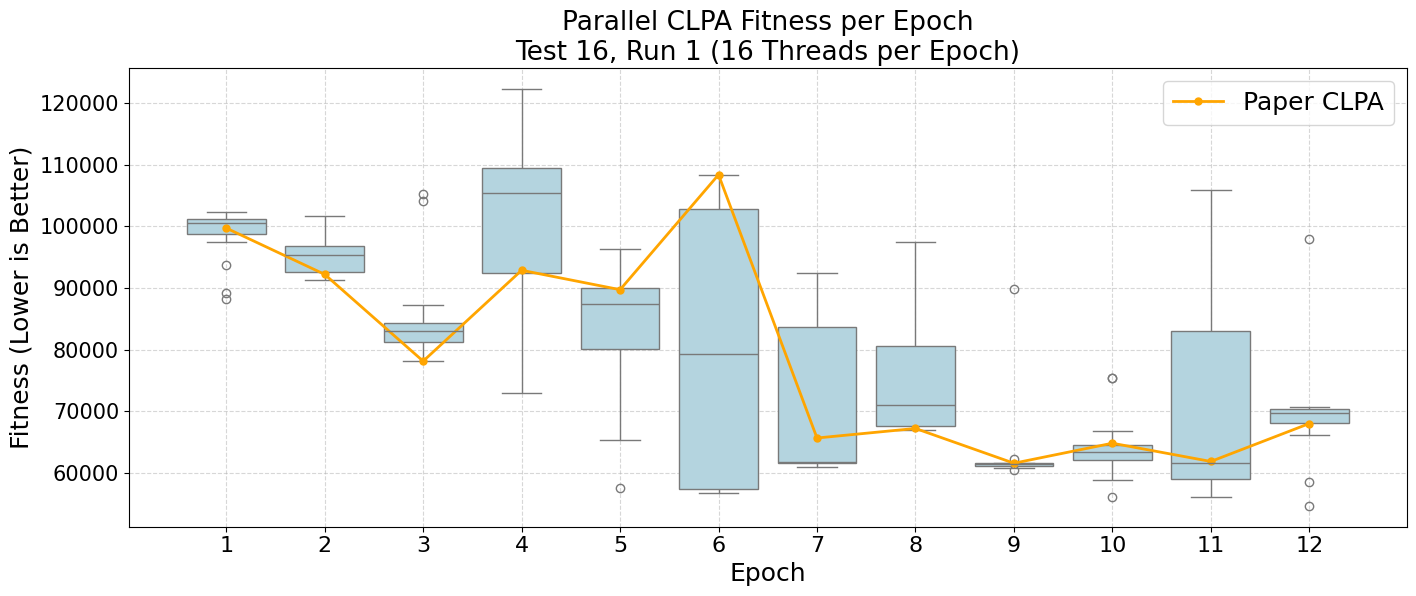

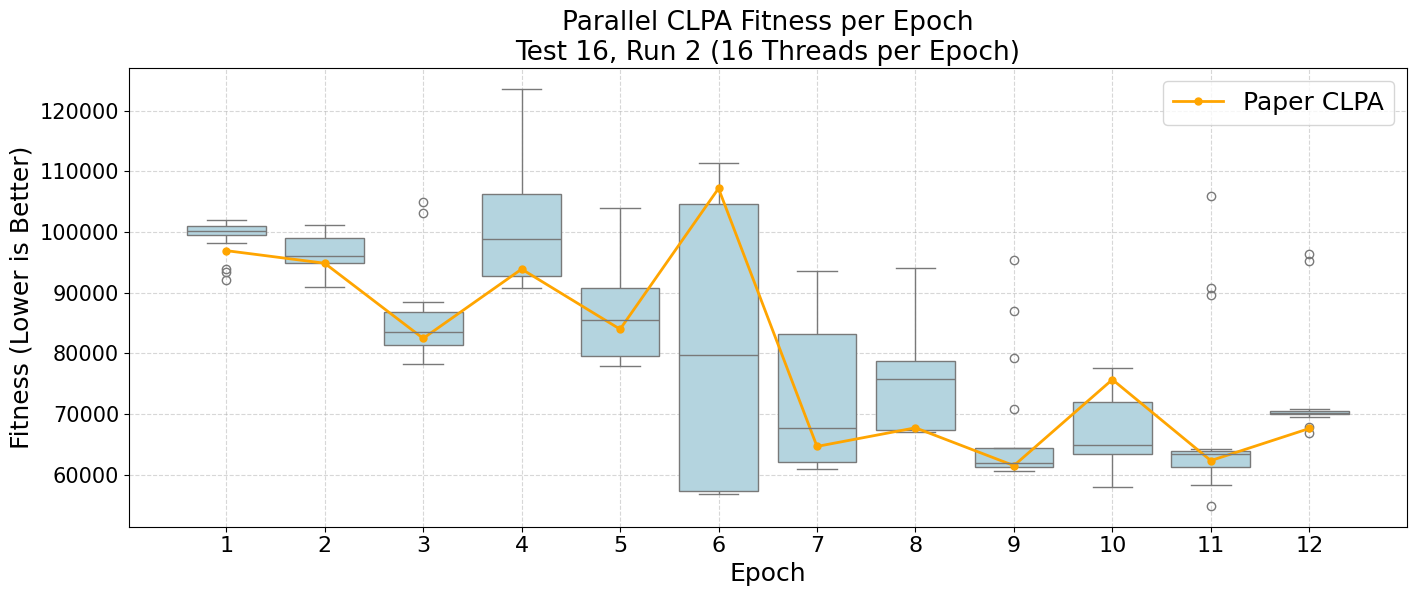

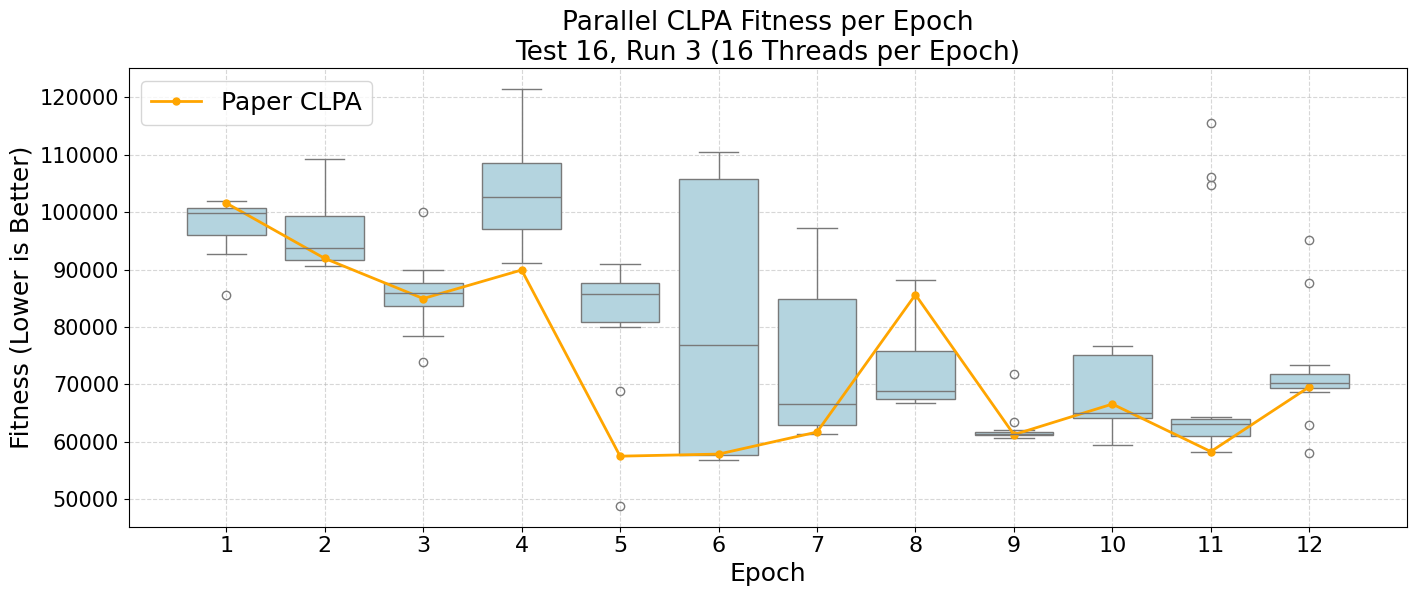

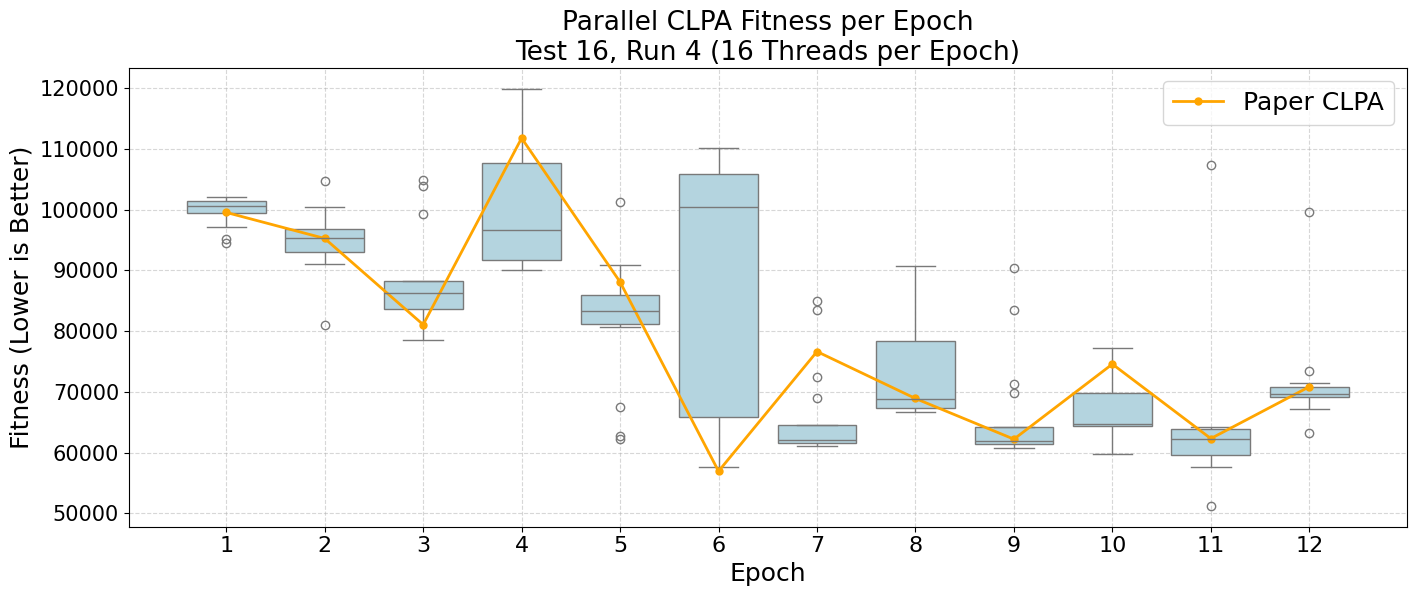

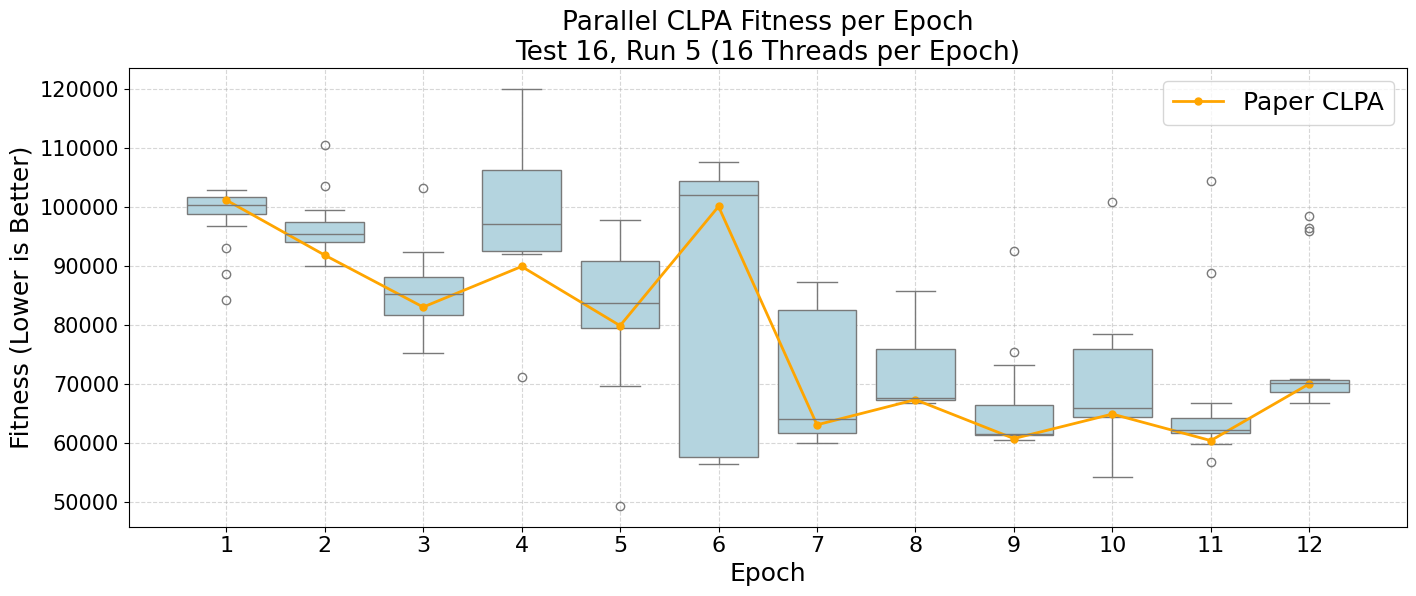

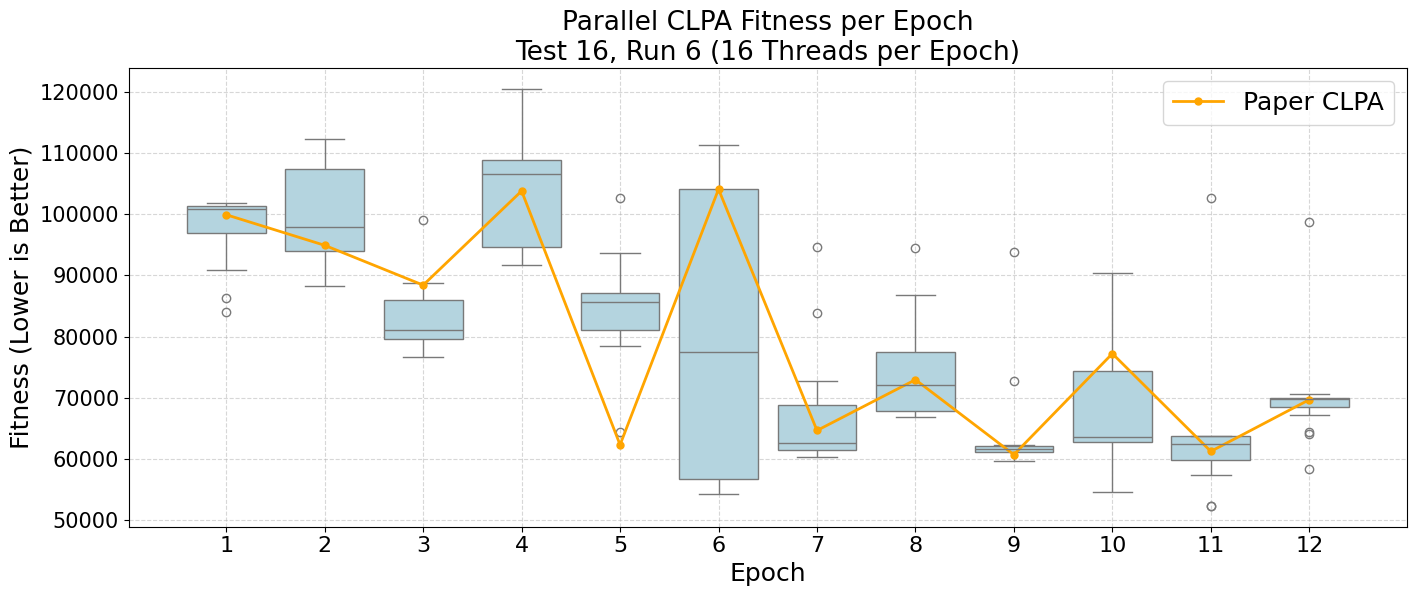

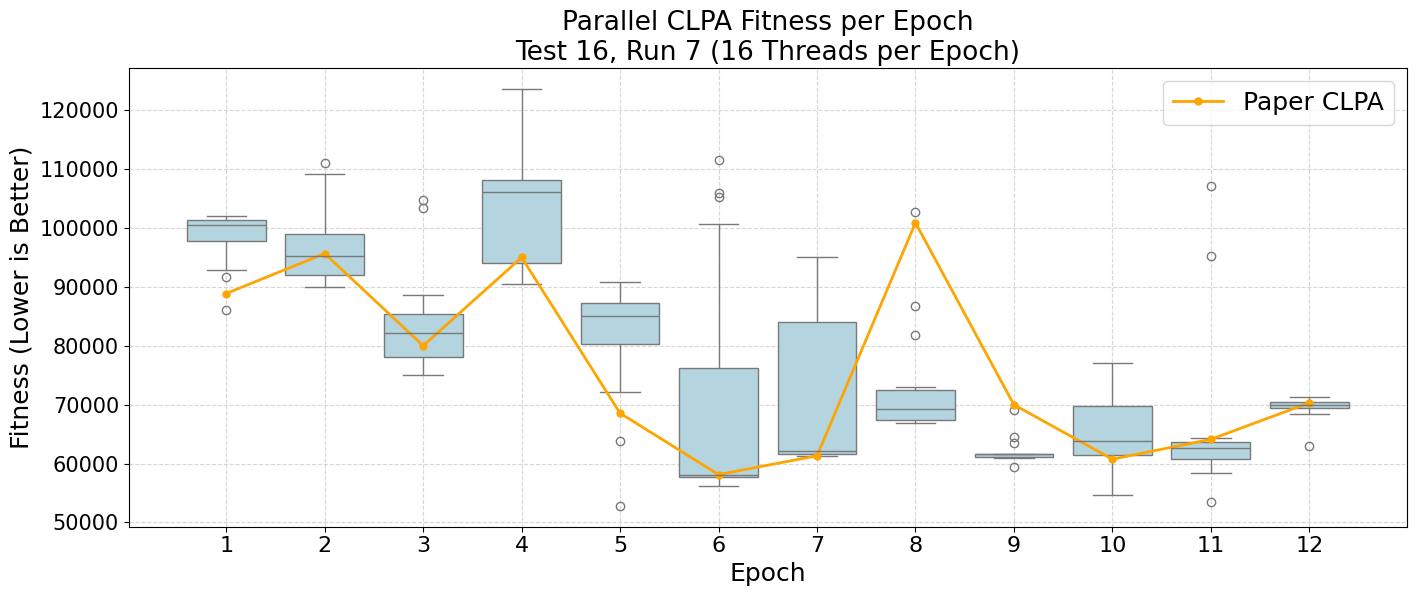

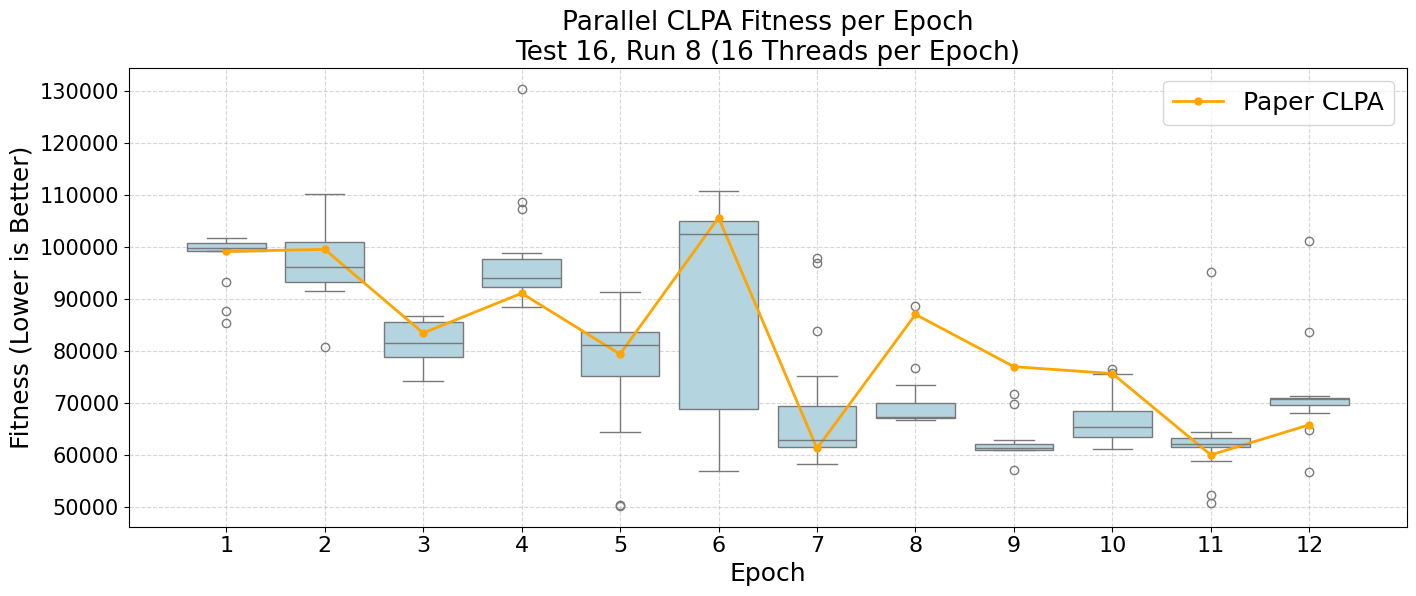

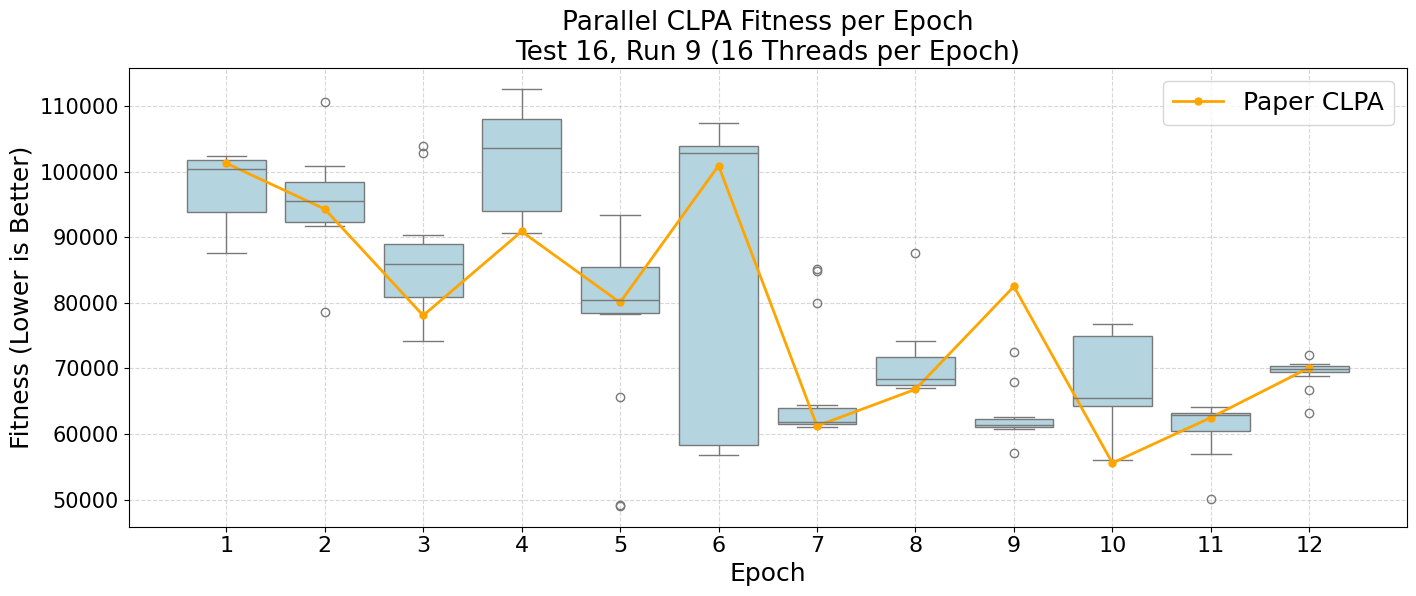

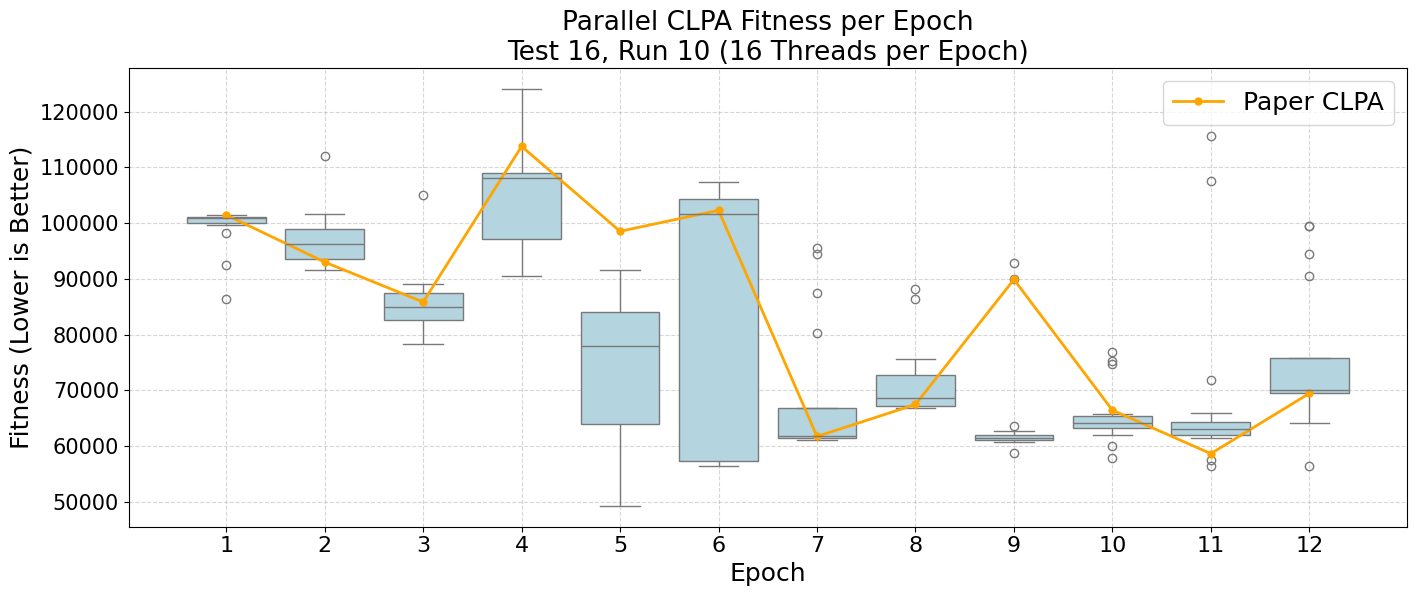

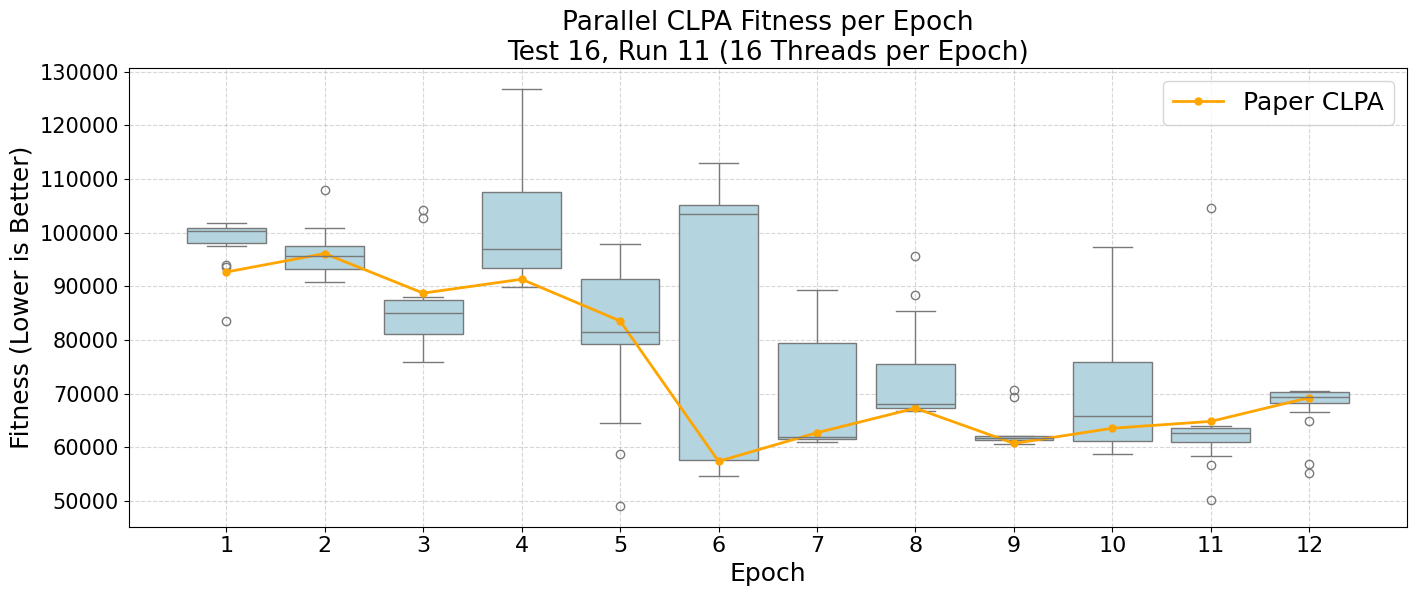

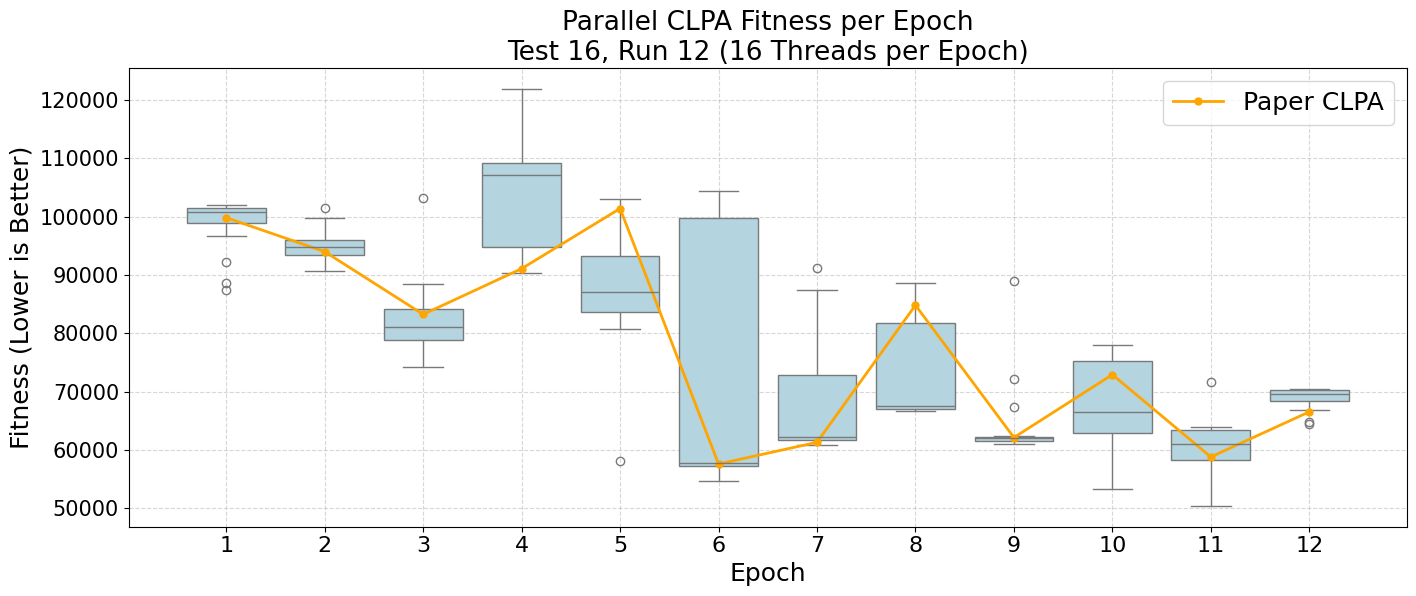

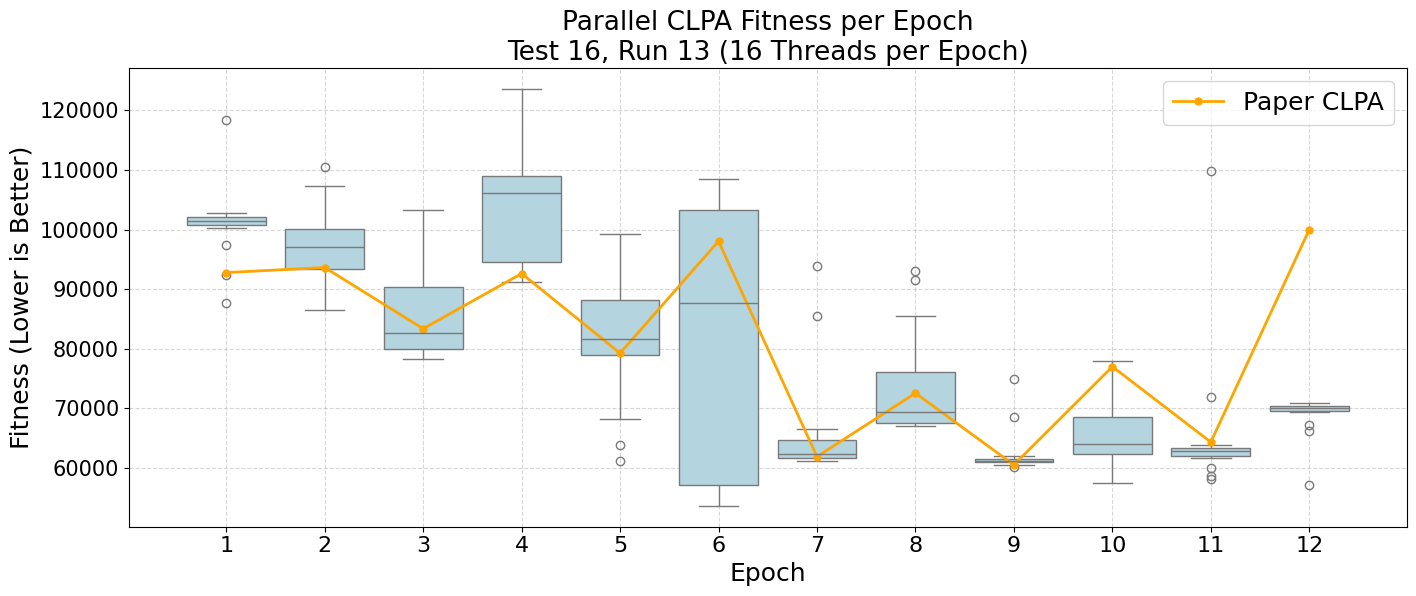

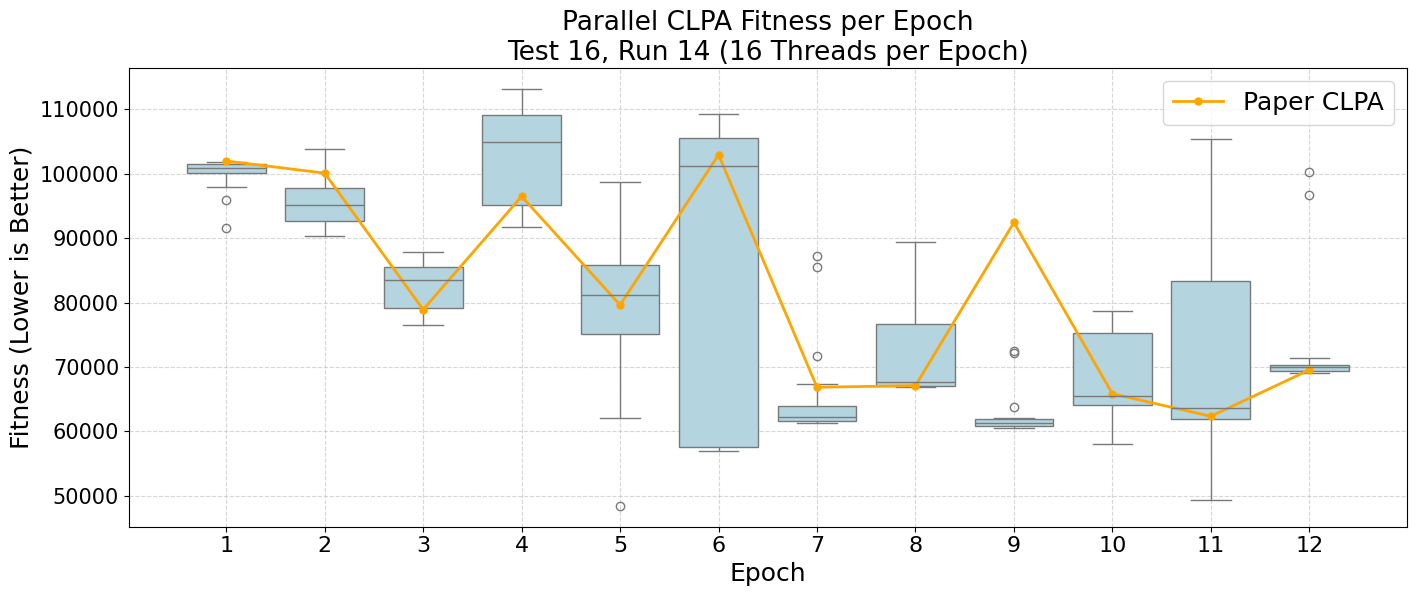

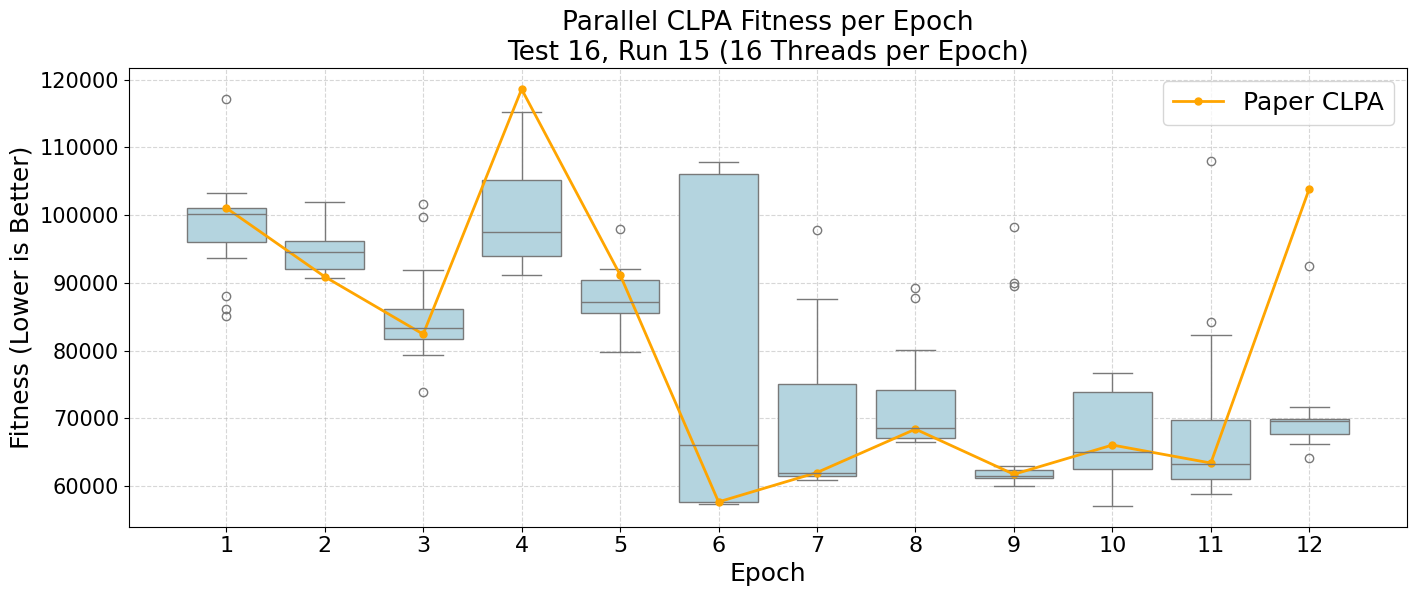

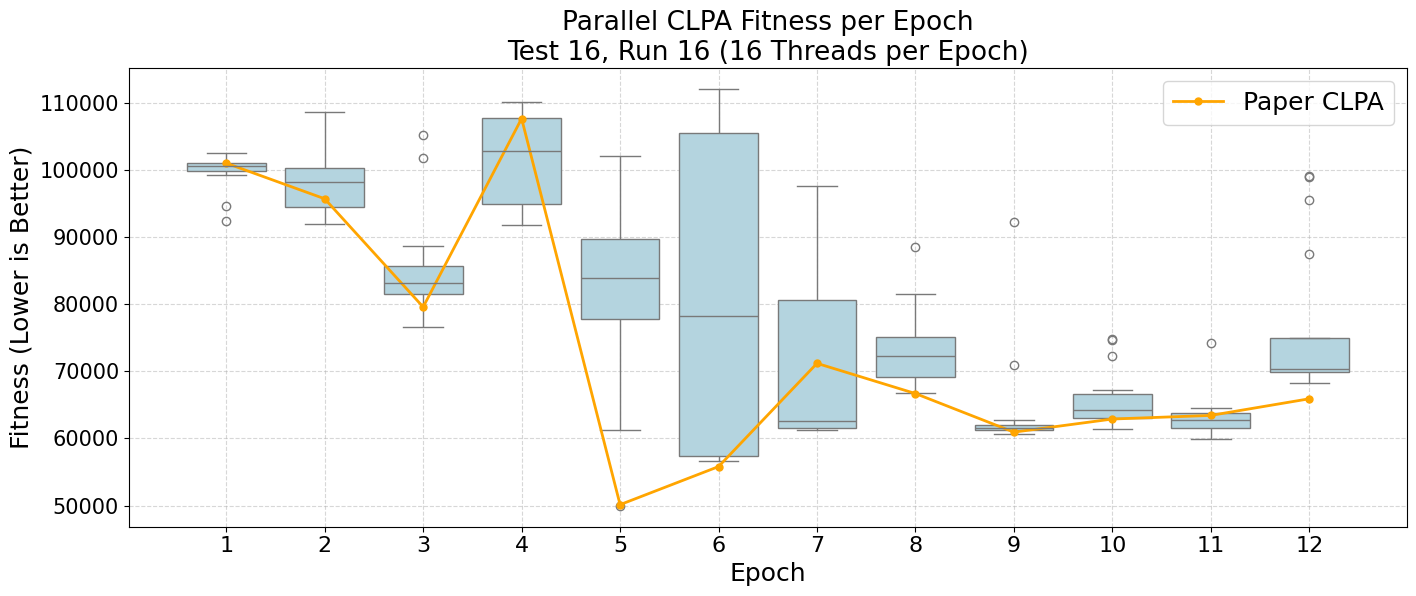

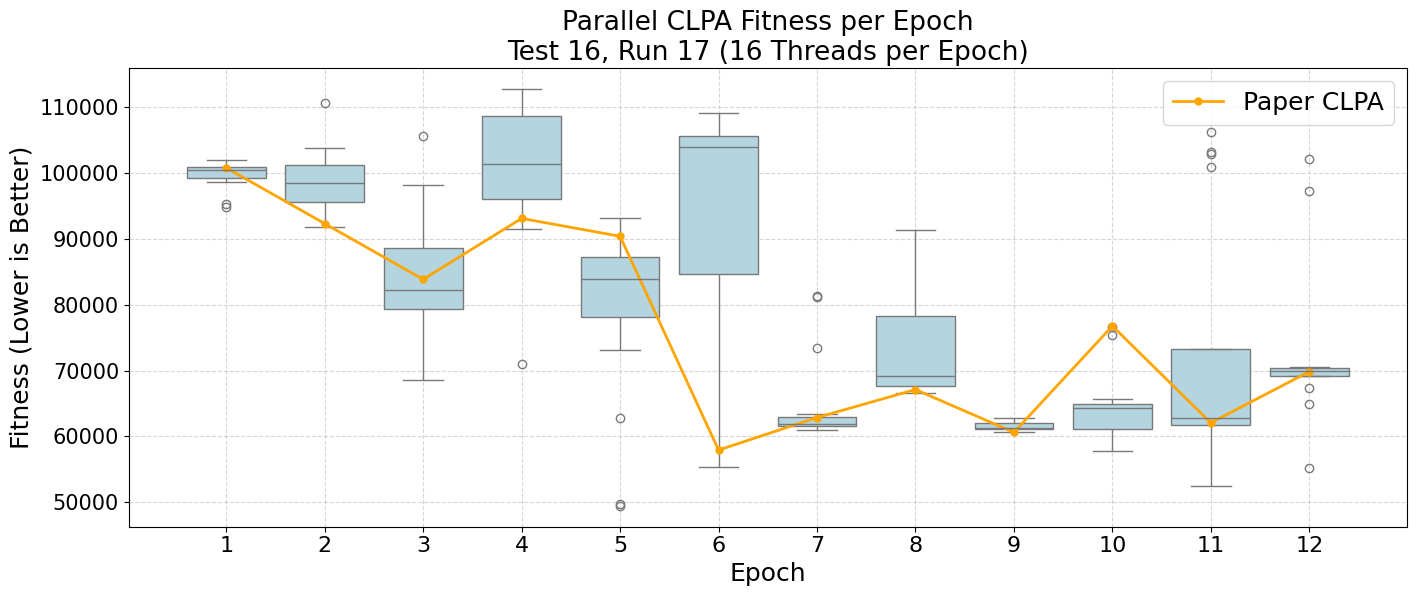

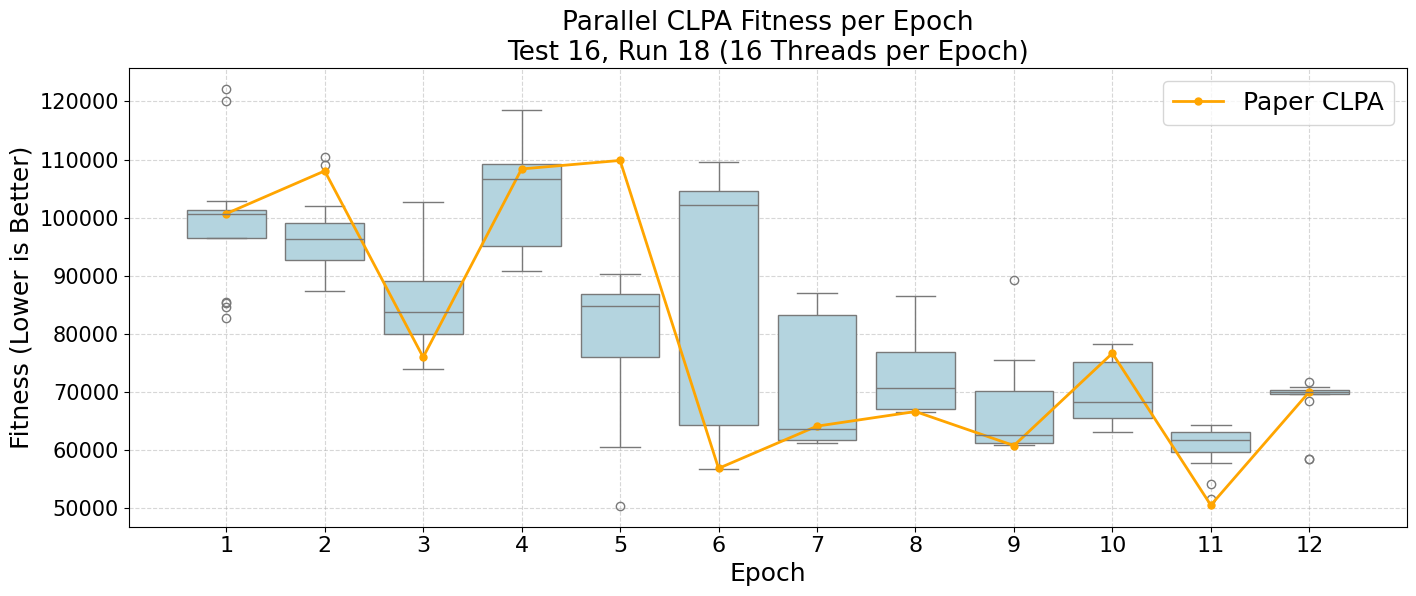

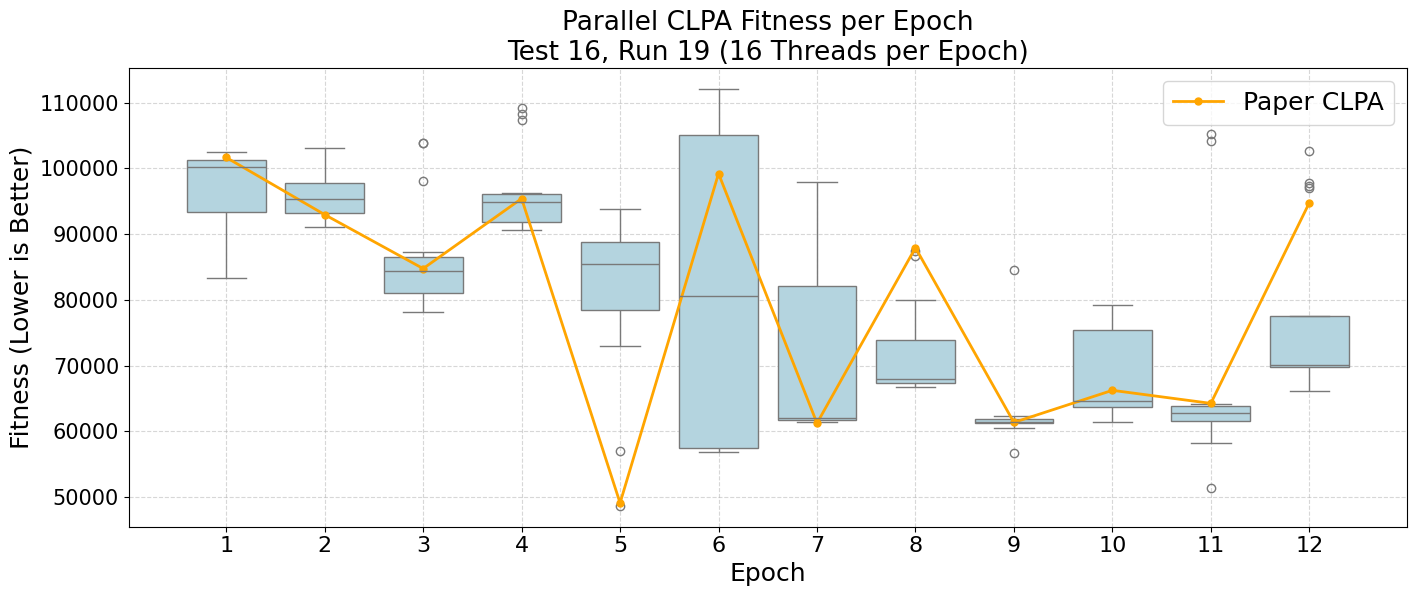

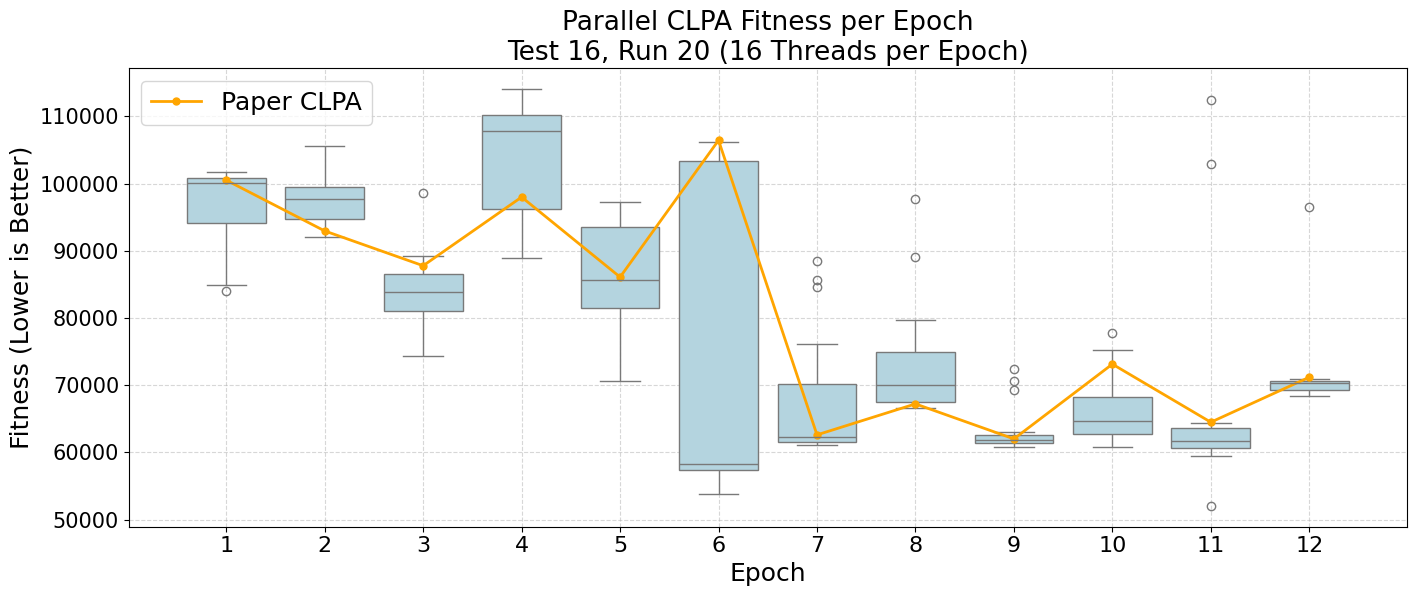

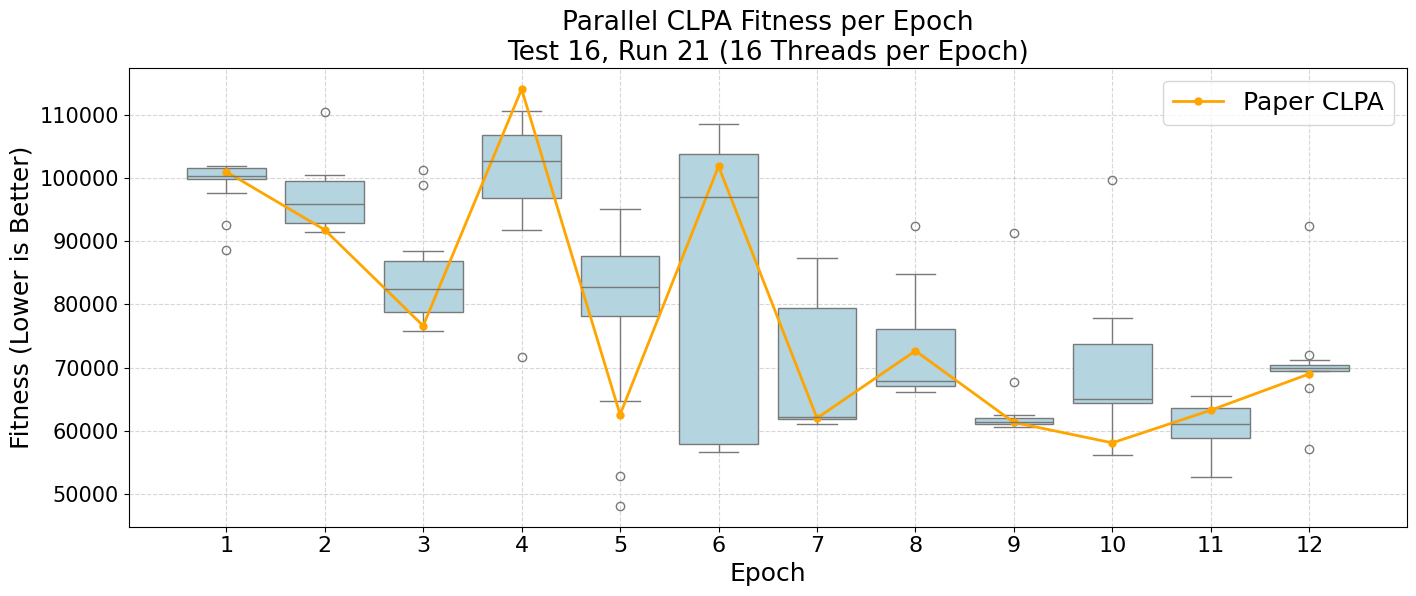

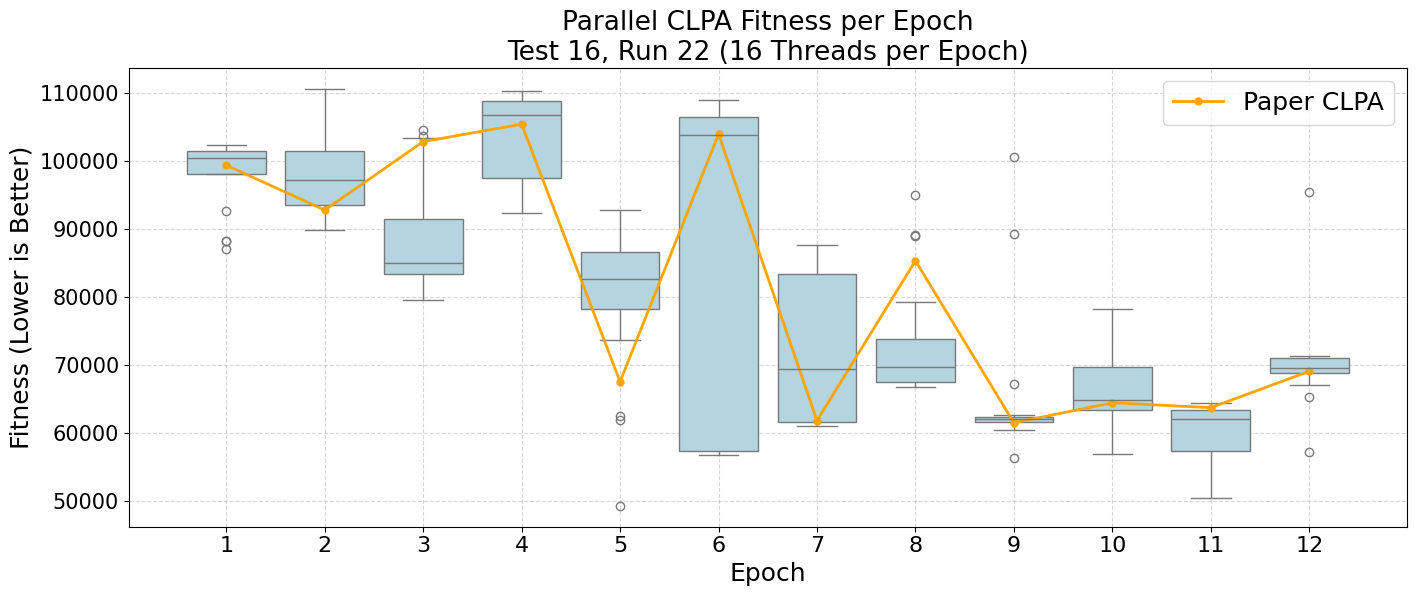

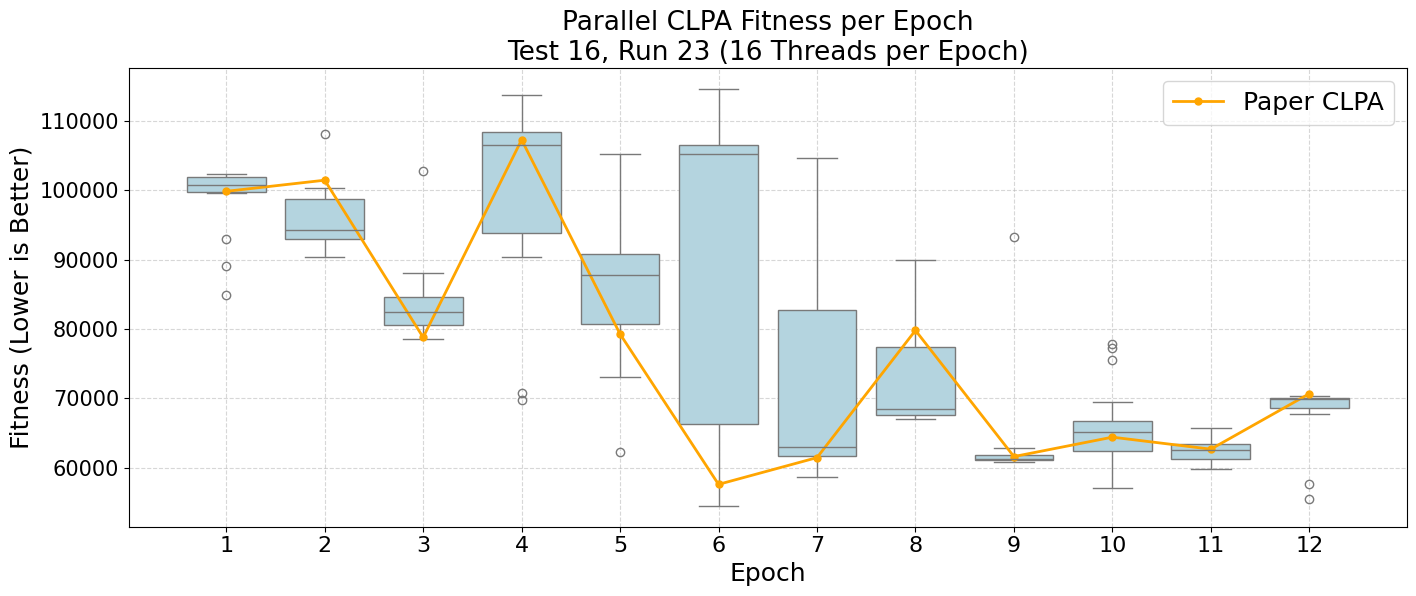

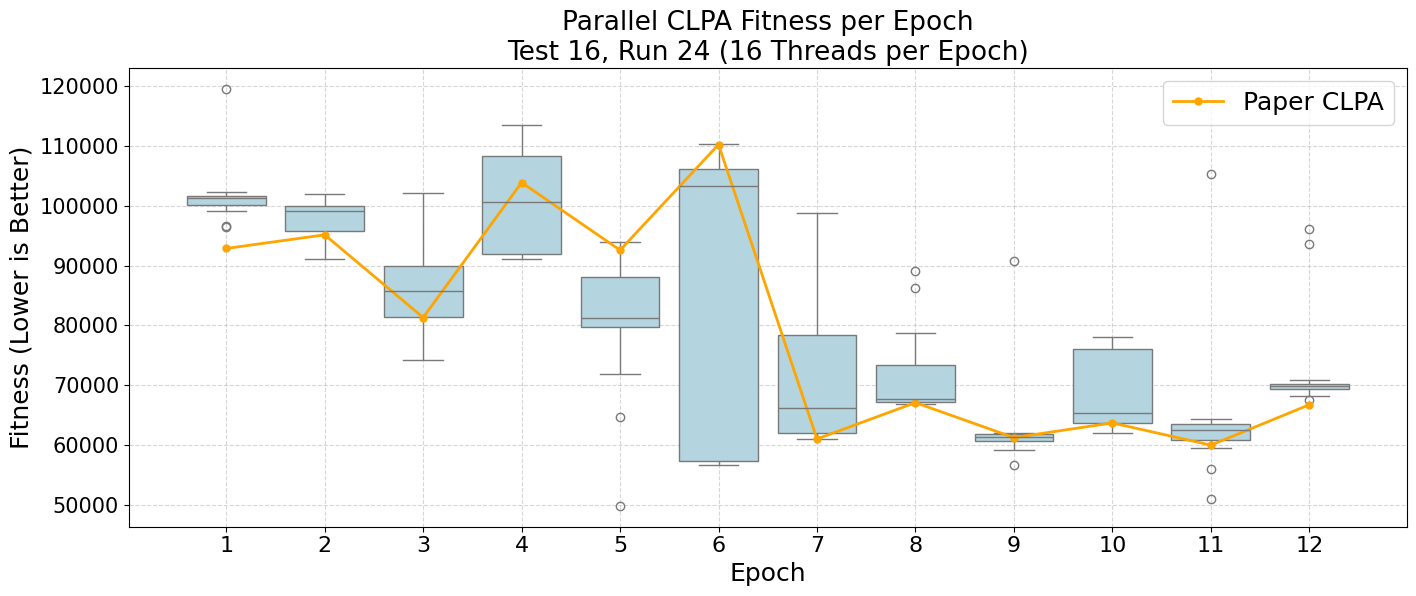

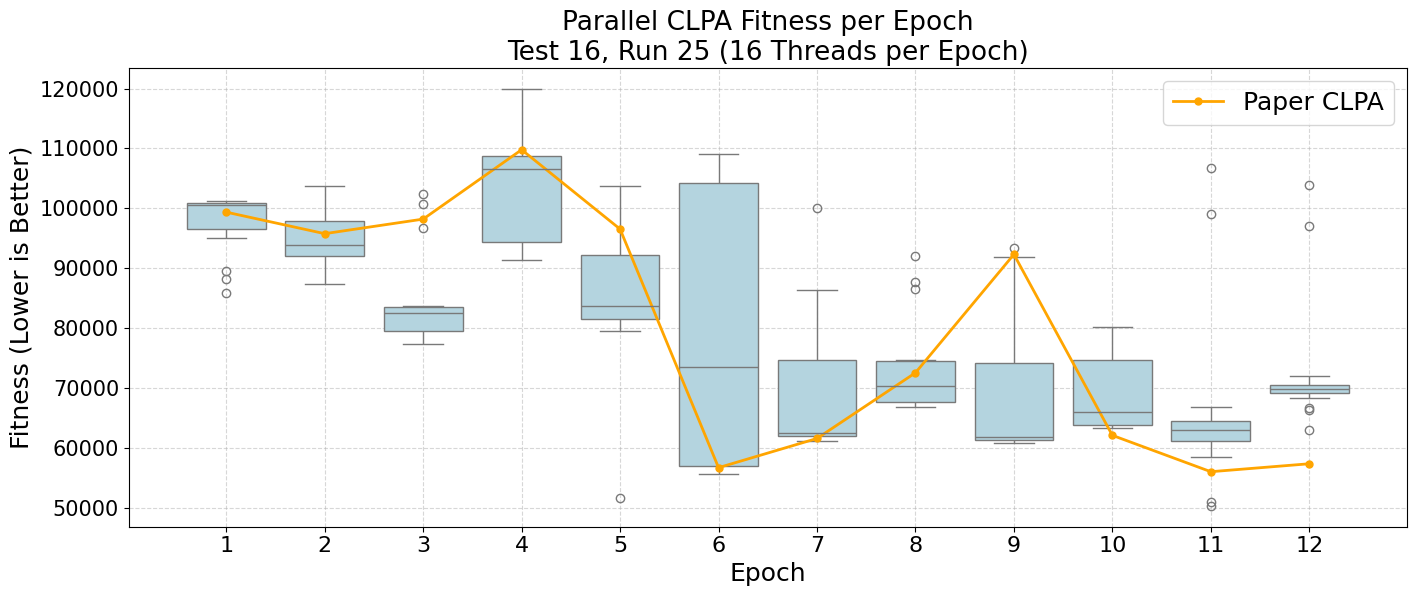

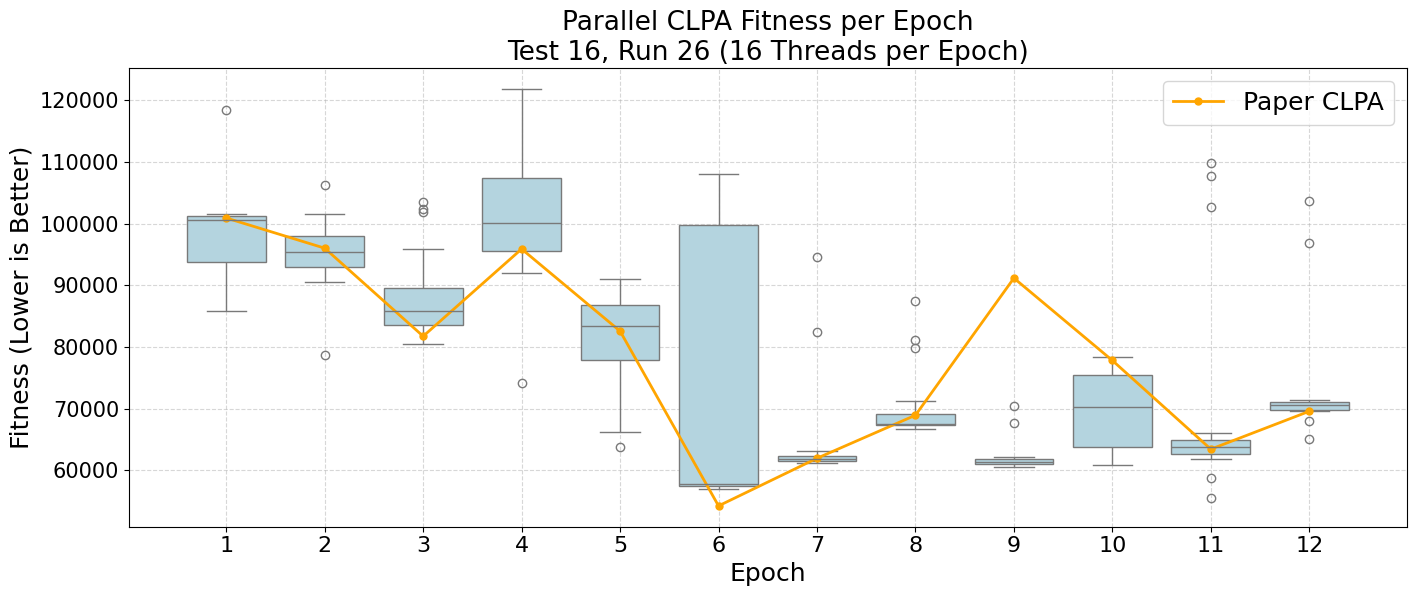

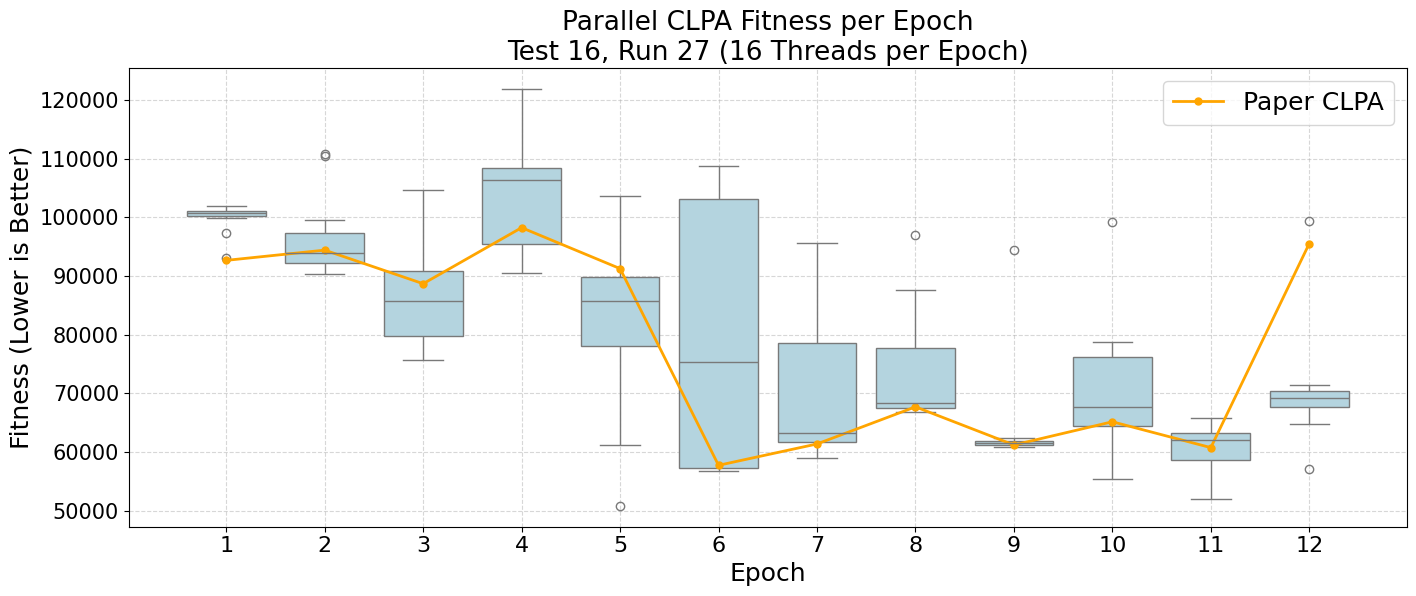

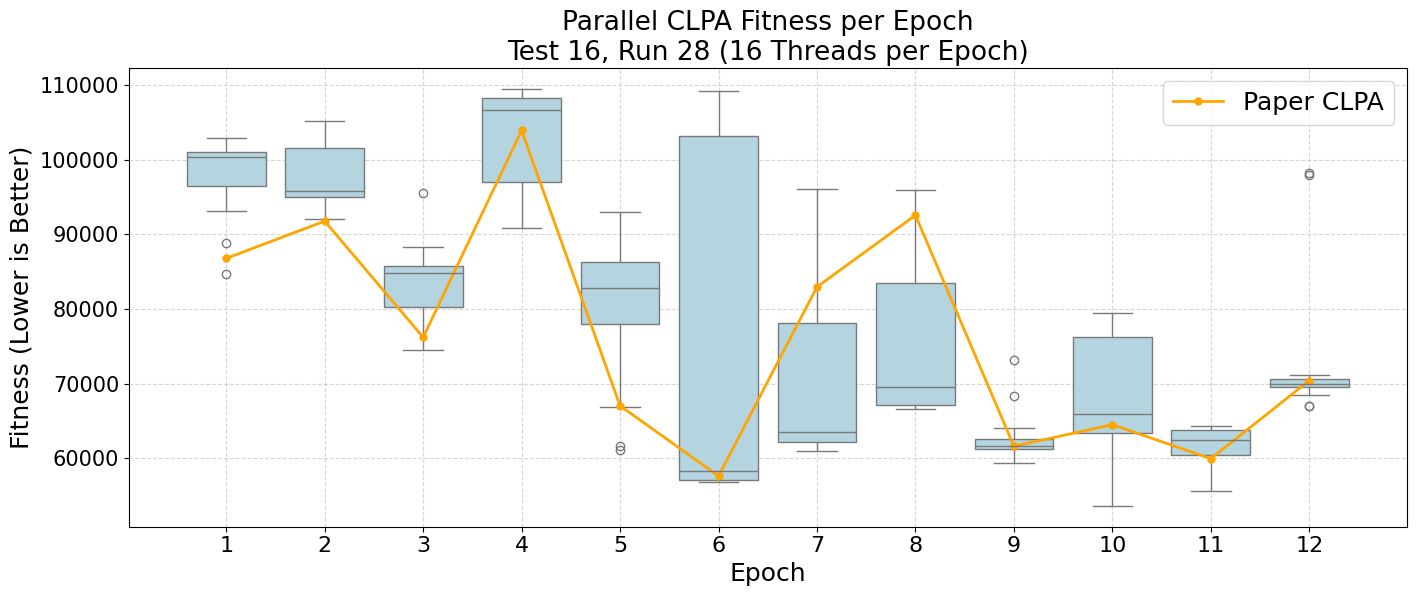

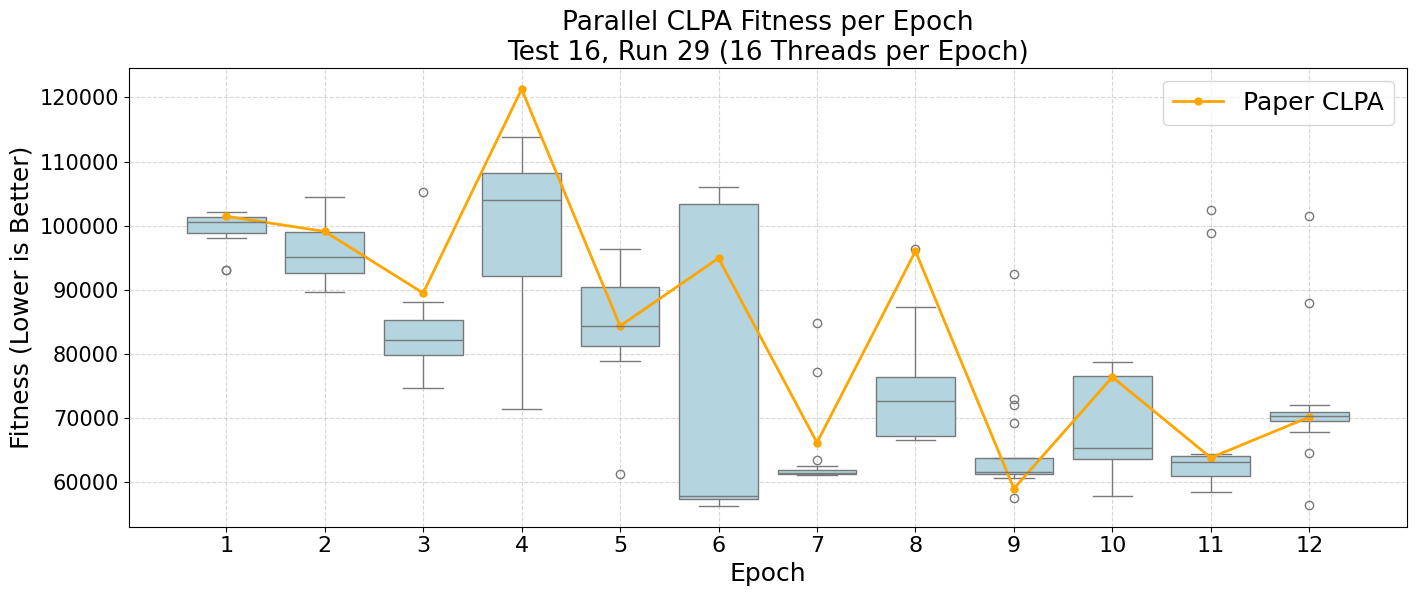

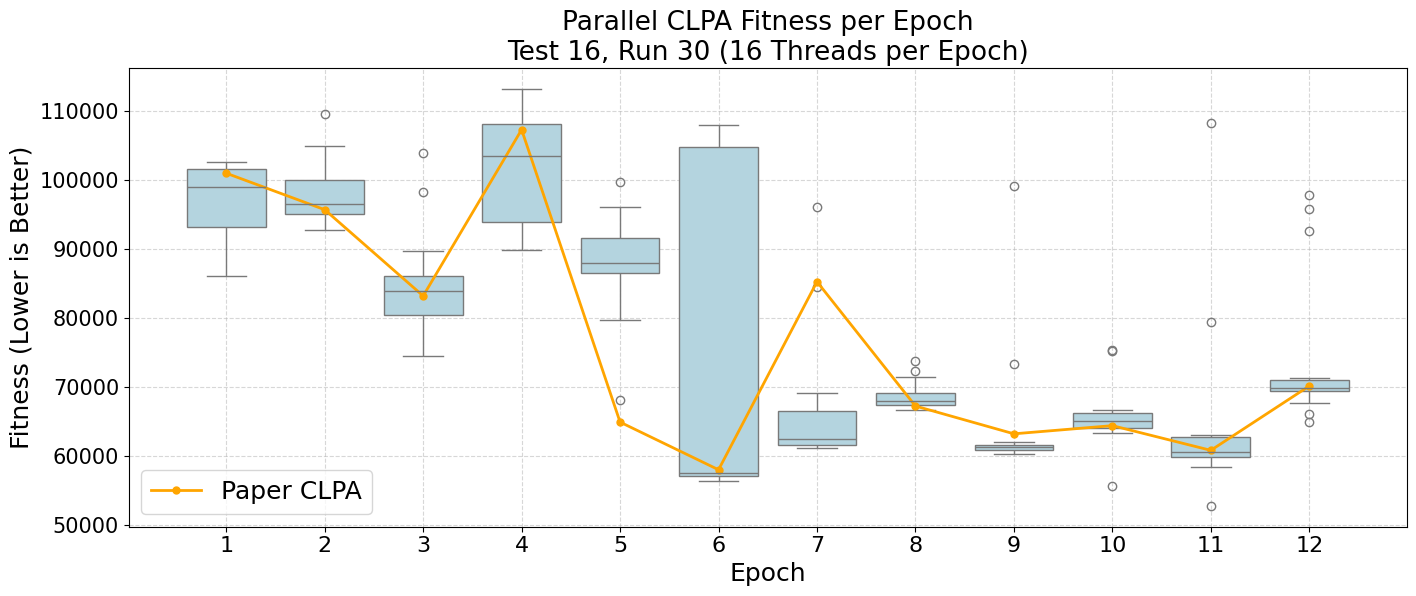

In [8]:
import seaborn as sns

# Choose the test to visualize
selected_test = 16

# Loop through all 30 runs
for run_id in range(1, 31):
    # Filter Parallel CLPA: all threads for this test+run
    parallel_subset = paper_clpa_parallel[
        (paper_clpa_parallel["test"] == selected_test) &
        (paper_clpa_parallel["run"] == run_id)
    ]

    # Filter Paper CLPA: only one value per epoch
    paper_subset = paper_clpa[
        (paper_clpa["test"] == selected_test) &
        (paper_clpa["run"] == run_id)
    ]

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Boxplot: distribution of fitness across 16 threads for each epoch
    sns.boxplot(x="epoch", y="fitness", data=parallel_subset, color="lightblue", showfliers=True)

    # Overlay: Paper CLPA (solid line with markers)
    plt.plot(
        paper_subset["epoch"] - 1,
        paper_subset["fitness"],
        label="Paper CLPA",
        color='orange',
        linestyle='-',
        linewidth=2,
        marker='o',
        markersize=5
    )

    # Labels and formatting
    plt.title(f"Parallel CLPA Fitness per Epoch\nTest {selected_test}, Run {run_id} (16 Threads per Epoch)", fontsize=19)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Fitness (Lower is Better)", fontsize=18)
    plt.legend(fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=15)

    plt.show()
